# 1. Imports

In [1]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor
from statistics import mean, stdev, median



In [16]:
from data_processing import get_clustered_data_with_bus_only, get_numeric_name, split_into_lines, get_train_and_test_by_lines

In [2]:
df = get_clustered_data_with_bus_only('./data/SZP-2021-09-03.csv')

Amount of invalid data: 2


In [5]:
df = get_numeric_name(df, "Nazwa przystanku", drop=True)

In [8]:
d_lines = split_into_lines(df, lower_bound = 2000)
len_d_lists=[]
for v in d_lines.values():
    len_d_lists.append(len(v))

In [9]:
print(f'Różnych linii jest : {len(d_lines)}')
print('Z czego:')
print(f'Min {min(len_d_lists)}')
print(f'MAx {max(len_d_lists)}')
print(f'Mean {mean(len_d_lists)}')
print(f'Std {stdev(len_d_lists)}')
print(f'Median {median(len_d_lists)}')

Różnych linii jest : 34
Z czego:
Min 2063
MAx 7014
Mean 3533.470588235294
Std 1047.2290199955573
Median 3289.0


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [45]:
def get_train_and_test_by_lines(df:pd.DataFrame, X_columns:list, y_columns:list, lines:list = None, lower_bound:int = 4000,  test_size=0.1, random_state=1):
    d_lines = split_into_lines(df, lower_bound=lower_bound)
    if lines is not None:
        for k in d_lines.keys:
            if not k in lines:
                del d_lines[k]
    X_trains = []
    X_tests = []
    y_trains = []
    y_tests = []
    for line in d_lines.values():
        X = line[X_columns]
        y = line[y_columns]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_trains.append(X_train)
        X_tests.append(X_test)
        y_trains.append(y_train)
        y_tests.append(y_test)
    
    df_x_train = pd.concat(X_trains)
    df_x_test = pd.concat(X_tests)
    df_y_train = pd.concat(y_trains)
    df_y_test = pd.concat(y_tests)

    return df_x_train, df_x_test, df_y_train, df_y_test

In [46]:
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, ['Nr linii', 'Numer taborowy', 'Godzina odjazdu',
       'Godzina odjazdu przedział', 'Numeryczna Nazwa przystanku',
       'Numeryczna Nazwa przystanku'], ["class"])

In [47]:
X_train.sample(3)

,Nr linii,Numer taborowy,Godzina odjazdu,Godzina odjazdu przedział,Numeryczna Nazwa przystanku,Numeryczna Nazwa przystanku
15363,123,9438,15.350000,61,176,176
103767,211,9246,12.316667,49,636,636
61739,179,9326,20.633333,82,1000,1000


In [48]:
len(X_train)

35861

## 1 autobus

In [175]:
tmp  = df['Nr linii'].unique()[0]
tmp

'102'

In [181]:
df = df[df['Nr linii'] == tmp]
N = len(df)
N

1845

## 5. Classification

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from mlxtend.evaluate import bootstrap_point632_score
from mlxtend.evaluate import BootstrapOutOfBag
from mlxtend.evaluate import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

In [259]:
df2 = df.sample(n = N, random_state = 100)
len(df2)

1845

In [14]:
df2 = df
df2 = df2.drop(columns=['Wariant linii','Nazwa przystanku', 'Numer przystanku', 'Rzeczywisty czas odjazdu', 'Rozkładowy czas odjazdu', 'Kurs', 'Oznaczenie brygady'], inplace= False)
df2 = df2.drop(columns=['Liczba pasaz. przed', 'Liczba wysiadających pasaz.', 'Liczba wsiadajacych pasaz.', 'Liczba pasaz. po odjezdzie'], inplace= False)
df2.sample(3)

,Nr linii,Numer taborowy,Godzina odjazdu,Godzina odjazdu przedział,class,Numeryczna nazwa przystanku,Numeryczna Nazwa przystanku
69998,181,9548,15.716667,62,pusto,264,264
111109,212,9693,17.355278,69,małe zatłoczenie,31,31
97881,208,9221,10.066667,40,małe zatłoczenie,832,832


In [15]:
X = df2.drop('class', axis=1, inplace= False)
X.sample(3)

,Nr linii,Numer taborowy,Godzina odjazdu,Godzina odjazdu przedział,Numeryczna nazwa przystanku,Numeryczna Nazwa przystanku
81294,193,9924,21.033333,84,1232,1232
76681,186,9918,16.616667,66,377,377
21583,127,9830,8.783333,35,896,896


In [16]:
features = X.columns[:]
print(features)

Index(['Nr linii', 'Numer taborowy', 'Godzina odjazdu',
       'Godzina odjazdu przedział', 'Numeryczna nazwa przystanku',
       'Numeryczna Nazwa przystanku'],
      dtype='object')


In [17]:
X.shape

(159727, 6)

In [18]:
y = df2["class"]
y.sample(3)

36586    małe zatłoczenie
32448               pusto
2511     małe zatłoczenie
Name: class, dtype: object

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## DecisionTreeClassifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [29]:
def create_tree(x, x_test, y, y_test, depth = 3):  
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 1)
    clf = clf.fit(x, y)
    err = accuracy_score(y_test, clf.predict(x_test))
    print("Accuracy: ", err)
    return err

In [38]:
tr1 = create_tree(X_train, X_test, y_train, y_test, depth = 2)

Accuracy:  0.39690850162054353


In [42]:
model = DecisionTreeClassifier(max_depth = 1000, random_state = 1)

In [52]:
#LeaveOneOut CrossValidation with negative mean absolute scores: the higher the scores, the lower mean absolute errors
scores1 = cross_validate(model, X_train, y_train, cv = LeaveOneOut(), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err1 = accuracy_score(scores1['estimator'][scores1['test_score'].argmax()].predict(X_test),y_test)

KeyboardInterrupt: 

In [49]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err2 = accuracy_score(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test),y_test)

In [50]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), scoring = 'neg_mean_absolute_error', return_estimator = True)
err3 = accuracy_score(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test),y_test)

In [51]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, scoring = 'neg_mean_absolute_error',return_estimator = True)
err4 = accuracy_score(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test), y_test)

In [54]:
print("------- Accuracy --------")
# print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.6327400350965154
3. Accuracy RepeatedKFold 0.6670844823263976
4. Accuracy KFold 0.6322386563048383


## Regresja

In [275]:
df3 = df.sample(n = N, random_state = 100)
len(df3)

1845

In [276]:
df3 = df3.loc[df['Typ']=='autobus']
df3 = df3.drop(columns=['Wariant linii','Nazwa przystanku', 'Numer przystanku', 'Rzeczywisty czas odjazdu', 'Rozkładowy czas odjazdu', 'Kurs', 'Oznaczenie brygady','Typ'], inplace= False)
df3 = df3.drop(columns=['Liczba wysiadających pasaz.', 'Liczba wsiadajacych pasaz.', 'Liczba pasaz. po odjezdzie', 'class'], inplace= False)
df3.sample(3)

,Nr linii,Numer taborowy,Liczba pasaz. przed,Godzina odjazdu,Godzina odjazdu przedział,Numeryczna nazwa przystanku
148767,712,9447,7,18.700000,74,549
131812,326,9673,28,8.645000,34,171
63392,179,9345,19,14.516667,58,1221


In [277]:
X = df3.drop('Liczba pasaz. przed', axis=1, inplace= False)
X.sample(3)

,Nr linii,Numer taborowy,Godzina odjazdu,Godzina odjazdu przedział,Numeryczna nazwa przystanku
50880,159,9554,15.383333,61,13
43529,157,9440,10.500000,42,1130
20473,127,9834,15.433333,61,432


In [278]:
y = df3["Liczba pasaz. przed"]
y.sample(3)

99644     10
7573      10
138361    26
Name: Liczba pasaz. przed, dtype: int64

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [280]:
model = DecisionTreeRegressor(max_depth = 1000, random_state = 1)

In [281]:
#LeaveOneOut CrossValidation with negative mean absolute scores: the higher the scores, the lower mean absolute errors
scores1 = cross_validate(model, X_train, y_train, cv = LeaveOneOut(), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err1 = abs(scores1['estimator'][scores1['test_score'].argmax()].predict(X_test) - y_test)

In [282]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err2 = abs(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test) - y_test)

In [283]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), scoring = 'neg_mean_absolute_error', return_estimator = True)
err3 = abs(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test) - y_test)

In [284]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, scoring = 'neg_mean_absolute_error',return_estimator = True)
err4 = abs(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test) - y_test)

In [285]:
d_err = []
d_err = pd.DataFrame({'Err':err1, 'Type': 'LOO'})
d_err = d_err.append(pd.DataFrame({'Err':err2, 'Type': 'BootOOB'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err3, 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4, 'Type': 'KFold'}),ignore_index=True)

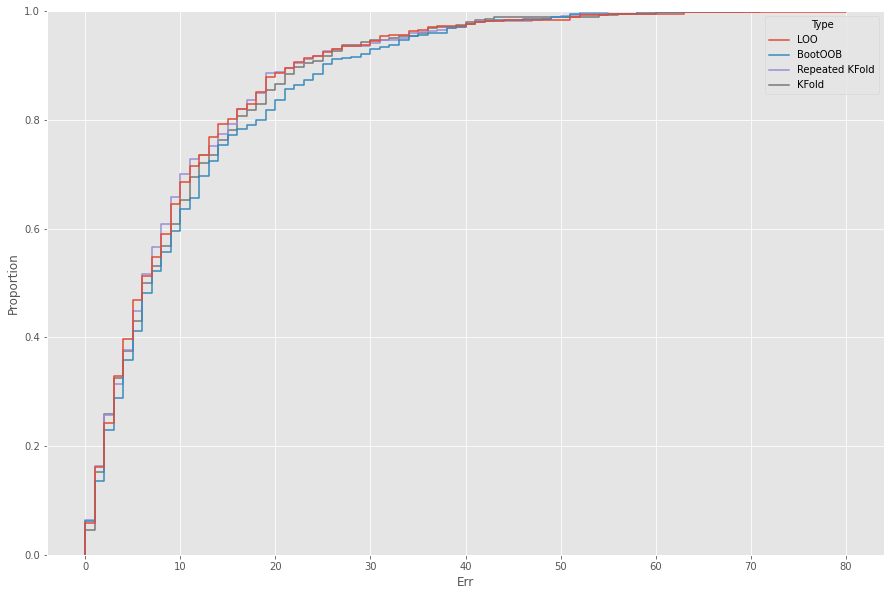

In [286]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [287]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                         
                count   mean    std  min  25%  50%   75%   max
Type                                                          
BootOOB         440.0  10.75  11.03  0.0  3.0  7.0  14.0  69.0
KFold           440.0  10.05  10.54  0.0  2.0  6.5  14.0  71.0
LOO             440.0   9.64  10.63  0.0  3.0  6.0  13.0  80.0
Repeated KFold  440.0   9.59  10.25  0.0  2.0  6.0  13.0  55.0